# Recovery of gold from ore

Prepare a prototype machine learning model for Zifra. The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore. Use data with mining and cleaning parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

You need to:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

## Tools/Libraries
*Python,* *Pandas,* *Scikit-learn,* *Matplotlib,* *Seaborn,* *Numpy*

## Description of data

**Technological process**
- Rougher feed - feedstock
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate - xanthate (promoter, or flotation activator);
    - Sulphate - sulfate (in this production, sodium sulfide);
    - Depressant - depressant (sodium silicate).
- Rougher process (English "rough process") - flotation
- Rougher tails
- Float banks - flotation unit
- Cleaner process - cleaning
- Rougher Au - rough gold concentrate
- Final Au - final gold concentrate

**Stage Options**
- air amount — air volume
- fluid levels - fluid level
- feed size - feed granule size
- feed rate - feed rate

**Feature name**

The name of the features should be:
[stage].[parameter_type].[parameter_name]
Example: rougher.input.feed_ag
Possible values ​​for block [stage]:
- rougher - flotation
- primary_cleaner - primary cleaning
- secondary_cleaner - secondary cleaning
- final - final characteristics
Possible values ​​for block [parameter_type]:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation - calculated characteristics

## Data preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import random
random_state=123
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Initial file study

In [2]:
train_data = pd.read_csv('/Users/vasily/Learning/Data Science/Projects/Gold recovery/gold_recovery_train_new.csv')
test_data = pd.read_csv('/Users/vasily/Learning/Data Science/Projects/Gold recovery/gold_recovery_test_new.csv')
full_data = pd.read_csv('/Users/vasily/Learning/Data Science/Projects/Gold recovery/gold_recovery_full_new.csv')

#train_data = pd.read_csv('/datasets/gold_recovery_train_new.csv')
#test_data = pd.read_csv('/datasets/gold_recovery_test_new.csv')
#full_data = pd.read_csv('/datasets/gold_recovery_full_new.csv')

print(train_data.describe())
print(train_data.info())

#print(test_data.sample(n=10, random_state=123))
print(test_data.info())

#print(full_data.sample(n=10, random_state=123))
print(full_data.info())

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 14148.000000                 14148.000000   
mean                      5.142034                    10.132960   
std                       1.369586                     1.654930   
min                       0.000000                     0.000000   
25%                       4.211620                     9.297355   
50%                       4.994652                    10.297144   
75%                       5.859540                    11.170603   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  13938.000000                 14149.000000   
mean                       9.202849                    44.003792   
std                        2.790516                     4.905261   
min                        0.000000                     0.000000   
25%                        7.484645                    4

### Checking the correctness of the calculation of the feature rougher.output.recovery on the training sample

In [3]:
train_data['rougher.output.recovery_calc'] = 100 * (train_data['rougher.output.concentrate_au']*(train_data['rougher.input.feed_au'] - train_data['rougher.output.tail_au'])/(train_data['rougher.input.feed_au']*(train_data['rougher.output.concentrate_au'] - train_data['rougher.output.tail_au'])))
mae = mean_absolute_error(train_data['rougher.output.recovery'], train_data['rougher.output.recovery_calc'])

print("MAE = ", mae)

train_data = train_data.drop('rougher.output.recovery_calc', axis=1)


MAE =  9.73512347450521e-15


MAE between the enrichment efficiency during flotation, calculated by us according to the formula and given in the training set, turned out to be negligible. This indicates that the enrichment efficiency in the data is calculated correctly.

### Comparison of the set of features in the training and test sets

In [4]:
diff_columns = set(train_data.columns) - set(test_data.columns)
diff_columns = list(sorted(diff_columns))
for column in diff_columns:
    print(column)
print(len(diff_columns))

final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.

**Conclusion**

In the test dataset, there are no features of the "output" type (that is, those that we can measure only after carrying out the flotation and purification processes) as well as the calculated characteristics. These parameters directly participate in the formula for calculating the target parameters rougher.output.recovery and final.output.recovery. This means that before training models on training data, these parameters must be excluded from the features.
On the other hand, to test the model, we will need to add target features from the full dataset to the test dataset.

### Data preprocessing

In [5]:
print(train_data.isna().sum().sum())
print(test_data.isna().sum().sum())

4100
90


**As part of data preprocessing, we will do the following:**
1. Cast the date column to date type instead of string.
2. Fill in the gaps in the columns with values from adjacent rows using the ffill() and bfill() methods.

In [6]:
#Приведем тип к date

train_data.date = pd.to_datetime(train_data.date)
test_data.date = pd.to_datetime(test_data.date)
full_data.date = pd.to_datetime(full_data.date)

train_data.set_index("date", inplace=True)
test_data.set_index("date", inplace=True)
full_data.set_index("date", inplace=True)

train_data.info()
print(train_data.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [7]:
#Заполним пропуски
train_data = train_data.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')
full_data = full_data.fillna(method='ffill')

train_data.info()
test_data.info()
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                     

## Анализ данных

### Анализ изменения концентрации металлов на различных этапах очистки

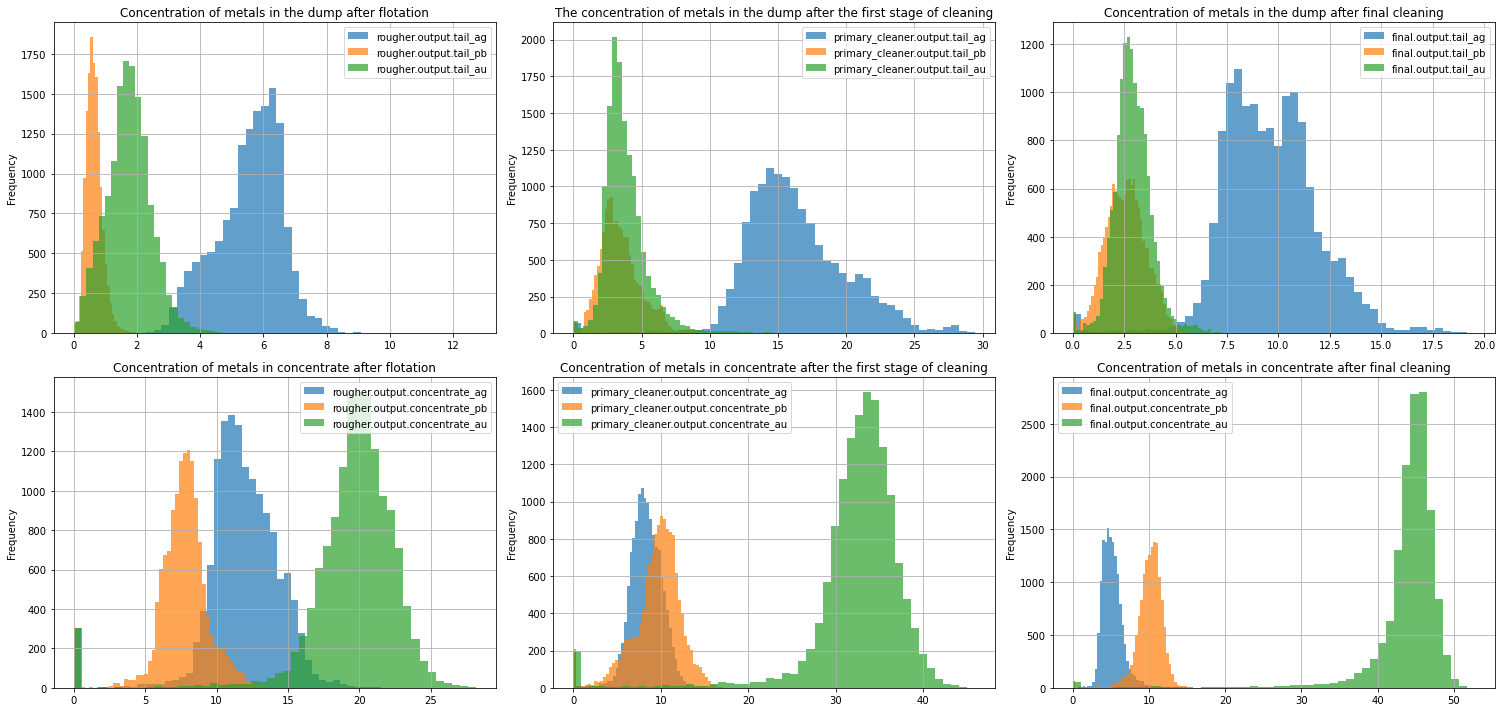

In [8]:
_, axs = plt.subplots(2,3, figsize=(21, 10))
train_data.plot(kind='hist', y='rougher.output.tail_ag', ax = axs[0][0], bins=50, grid=True,  alpha=0.7, title = 'Concentration of metals in the dump after flotation')
train_data.plot(kind='hist', y='rougher.output.tail_pb', ax = axs[0][0], bins=50, grid=True, alpha=0.7)
train_data.plot(kind='hist', y='rougher.output.tail_au', ax = axs[0][0], bins=50, grid=True, alpha=0.7)

train_data.plot(kind='hist', y='rougher.output.concentrate_ag', ax = axs[1][0], bins=50, grid=True,  alpha=0.7, title = 'Concentration of metals in concentrate after flotation')
train_data.plot(kind='hist', y='rougher.output.concentrate_pb', ax = axs[1][0], bins=50, grid=True, alpha=0.7)
train_data.plot(kind='hist', y='rougher.output.concentrate_au', ax = axs[1][0], bins=50, grid=True, alpha=0.7)

train_data.plot(kind='hist', y='primary_cleaner.output.tail_ag', ax = axs[0][1], bins=50, grid=True,  alpha=0.7, title = 'The concentration of metals in the dump after the first stage of cleaning')
train_data.plot(kind='hist', y='primary_cleaner.output.tail_pb', ax = axs[0][1], bins=50, grid=True, alpha=0.7)
train_data.plot(kind='hist', y='primary_cleaner.output.tail_au', ax = axs[0][1], bins=50, grid=True, alpha=0.7)

train_data.plot(kind='hist', y='primary_cleaner.output.concentrate_ag', ax = axs[1][1], bins=50, grid=True,  alpha=0.7, title = 'Concentration of metals in concentrate after the first stage of cleaning')
train_data.plot(kind='hist', y='primary_cleaner.output.concentrate_pb', ax = axs[1][1], bins=50, grid=True, alpha=0.7)
train_data.plot(kind='hist', y='primary_cleaner.output.concentrate_au', ax = axs[1][1], bins=50, grid=True, alpha=0.7)

train_data.plot(kind='hist', y='final.output.tail_ag', ax = axs[0][2], bins=50, grid=True,  alpha=0.7, title = 'Concentration of metals in the dump after final cleaning')
train_data.plot(kind='hist', y='final.output.tail_pb', ax = axs[0][2], bins=50, grid=True, alpha=0.7)
train_data.plot(kind='hist', y='final.output.tail_au', ax = axs[0][2], bins=50, grid=True, alpha=0.7)

train_data.plot(kind='hist', y='final.output.concentrate_ag', ax = axs[1][2], bins=50, grid=True,  alpha=0.7, title = 'Concentration of metals in concentrate after final cleaning')
train_data.plot(kind='hist', y='final.output.concentrate_pb', ax = axs[1][2], bins=50, grid=True, alpha=0.7)
train_data.plot(kind='hist', y='final.output.concentrate_au', ax = axs[1][2], bins=50, grid=True, alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusion**
1. Distributions of metal concentrations are generally close to normal.
2. The proportion of gold in the concentrate gradually increases from flotation to final refining. Conversely, the concentration of other metals decreases.
3. Anomalous zero values of concentrations in the dumps and at the outlet (concentrate) can be seen.

### Comparison of the size distribution of raw material granules on the training and test samples

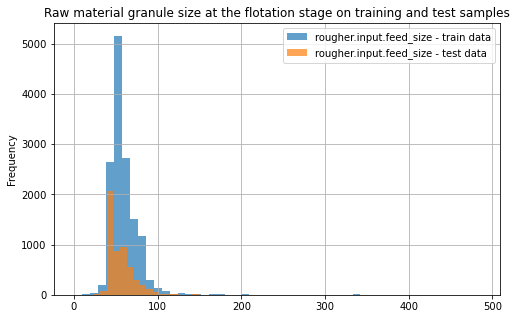

In [9]:

area_plot = train_data.plot(kind='hist', y='rougher.input.feed_size', figsize = (8,5), bins=50, grid=True,  alpha=0.7, title = 'Raw material granule size at the flotation stage on training and test samples')
test_data.plot(kind='hist', y='rougher.input.feed_size', ax = area_plot, bins=50, grid=True,  alpha=0.7)
plt.legend(['rougher.input.feed_size - train data', 'rougher.input.feed_size - test data'])
plt.show()


**Conclusion**

The size distributions of raw material granules on the test and training samples are similar, there are no strong differences.

### Study of the total concentration of all substances at different stages

Let us stidy the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.

<AxesSubplot:title={'center':'Concentration of substances at different stages'}, ylabel='Frequency'>

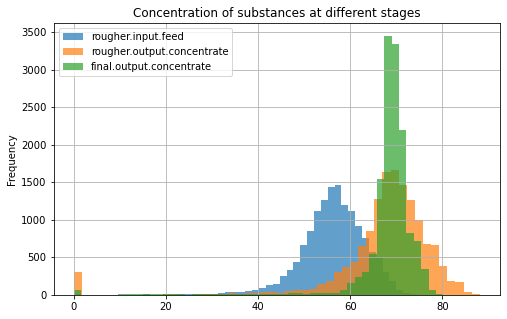

In [10]:
substance = ['au', 'ag', 'pb', 'sol']
columns = ['rougher.input.feed',\
           'rougher.output.concentrate','final.output.concentrate']

columns = [f"{t}_{m}" for t,m in zip(columns*4,substance*3)]
df_temp = train_data[columns]
df_temp['rougher.input.feed'] = df_temp['rougher.input.feed_au']+ \
df_temp['rougher.input.feed_ag']+df_temp['rougher.input.feed_pb']+df_temp['rougher.input.feed_sol']

df_temp['rougher.output.concentrate'] = df_temp['rougher.output.concentrate_au'] + \
df_temp['rougher.output.concentrate_ag'] + df_temp['rougher.output.concentrate_pb'] + df_temp['rougher.output.concentrate_sol']

df_temp['final.output.concentrate'] = df_temp['final.output.concentrate_au'] + df_temp['final.output.concentrate_ag'] + \
df_temp['final.output.concentrate_pb'] + df_temp['final.output.concentrate_sol']


area_plot = df_temp.plot(kind='hist', y='rougher.input.feed', figsize = (8,5), bins=50, grid=True,  alpha=0.7, title = 'Concentration of substances at different stages')
df_temp.plot(kind='hist', y='rougher.output.concentrate', ax = area_plot, bins=50, grid=True, alpha=0.7)
df_temp.plot(kind='hist', y='final.output.concentrate', ax = area_plot, bins=50, grid=True, alpha=0.7)



**Conclusion**

As can be seen, there are anomalous emissions with zero values of the total concentrations of substances at the outlet of flotation and final cleaning. We remove such records from the training sample. There are no signs of concentrates in the test sample, so we will check for deletion only records with zero total concentration of raw materials.

In [11]:
#Removing anomalous rows from the training set
print(train_data.shape)
print(test_data.shape)
train_data = train_data.drop(train_data[(train_data['rougher.input.feed_au'] + \
                                         train_data['rougher.input.feed_ag'] + \
                                         train_data['rougher.input.feed_pb'] + \
                                         train_data['rougher.input.feed_sol'] == 0) | \
                                        (train_data['rougher.output.concentrate_au'] + \
                                         train_data['rougher.output.concentrate_ag'] + \
                                         train_data['rougher.output.concentrate_pb'] + \
                                         train_data['rougher.output.concentrate_sol'] == 0) | \
                                        (train_data['final.output.concentrate_au'] + \
                                         train_data['final.output.concentrate_ag'] + \
                                         train_data['final.output.concentrate_pb'] + \
                                         train_data['final.output.concentrate_sol'] == 0)].index)
#Removing anomalous rows from the test set
test_data = test_data.drop(test_data[test_data['rougher.input.feed_au'] + \
                                         test_data['rougher.input.feed_ag'] + \
                                         test_data['rougher.input.feed_pb'] + \
                                         test_data['rougher.input.feed_sol'] == 0].index)
print(train_data.shape)
print(test_data.shape)



(14149, 86)
(5290, 52)
(13795, 86)
(5290, 52)


## Model

### Function for calculation of sMAPE

(Symmetric Mean Absolute Percentage Error).

In [12]:
def smape(y_true, y_pred):
    frac = np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2)
    return np.average(frac, axis=0)

def smape_final(y_true, y_pred):
    smape_out_rougher = smape(y_true[:,0], y_pred[:,0])
    smape_out_final = smape(y_true[:,1], y_pred[:,1])
    return 0.25*smape_out_rougher + 0.75*smape_out_final

### Building and assessing the quality of models

In [13]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(test_data.columns))

#Add columns with targets to the test set
test_data = test_data.merge(full_data[target], how = 'left', left_index=True, right_index=True)

test_data.head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432


In [14]:
#Let's form samples with features and targets
X_train, X_test = train_data[features].values, test_data[features].values
Y_train, Y_test = train_data[target].values, test_data[target].values

print(X_train.shape)
print(Y_train.shape)


(13795, 52)
(13795, 2)


In [15]:
Y_train, Y_test

(array([[87.10776293, 70.54121591],
        [86.84326051, 69.26619763],
        [86.84230826, 68.11644507],
        ...,
        [88.89057853, 67.00218885],
        [89.858126  , 65.52324622],
        [89.51495973, 70.28145415]]),
 array([[89.99342112, 70.27358301],
        [88.0896569 , 68.91043193],
        [88.41275562, 68.14321308],
        ...,
        [93.01813839, 67.09275914],
        [92.59904222, 68.06118648],
        [91.1776948 , 71.69997576]]))

In [16]:
smape_score = make_scorer(smape_final, greater_is_better=False)

In [17]:
#Training and testing of linear regression model

lr = LinearRegression().fit(X_train, Y_train)
#Y_predict = lr.predict(X_train)
#print(Y_predict)
#print(Y_train)
scores_lr = cross_val_score(lr, X_train, Y_train, cv=5, scoring=smape_score)
print("Mean sMAPE using Linear Regression model:", scores_lr.mean())
scores_lr

Mean sMAPE using Linear Regression model: -0.10059602069093501


array([-0.12187669, -0.08827009, -0.08471136, -0.08164526, -0.1264767 ])

In [18]:
%%time

#Training and testing decision tree model
params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(3,15)}
grid = GridSearchCV(DecisionTreeRegressor(random_state=random_state),param_grid=params, scoring=smape_score, cv=5, refit=True)
grid.fit(X_train, Y_train)
best_params = grid.best_params_
print(best_params)

dtr = grid.best_estimator_
scores_dtr = cross_val_score(dtr, X_train, Y_train, cv=5, scoring=smape_score)
print("Mean sMAPE using Decision Tree Regression model:", scores_dtr.mean())
scores_dtr

{'max_depth': 3, 'min_samples_split': 2}
Mean sMAPE using Decision Tree Regression model: -0.09173898877615536
CPU times: user 1min 33s, sys: 523 ms, total: 1min 33s
Wall time: 1min 33s


array([-0.09388593, -0.08685966, -0.09095162, -0.08223203, -0.1047657 ])

In [19]:
%%time

#Training and testing random forest model

params = {'n_estimators': range(10, 31, 5), 
         'max_depth': range(3, 15, 1)}
grid = GridSearchCV(RandomForestRegressor(random_state=random_state), param_grid=params, scoring=smape_score, cv=5, refit=True)
grid.fit(X_train, Y_train)
best_params = grid.best_params_
print(best_params)

rfr = grid.best_estimator_
scores_rfr = cross_val_score(rfr, X_train, Y_train, cv=5, scoring=smape_score)
print("Mean sMAPE using Random Forest Regressor:", scores_rfr.mean())
scores_rfr

{'max_depth': 3, 'n_estimators': 30}
Mean sMAPE using Random Forest Regressor: -0.0873923697478142
CPU times: user 22min 46s, sys: 3.51 s, total: 22min 49s
Wall time: 22min 55s


array([-0.09097225, -0.07711255, -0.08158659, -0.08540182, -0.10188864])

The best (smallest) value of sMAE in cross-validation was shown by the Decision Tree model. Let's check it on a test sample.

In [20]:
Y_test_predict = rfr.predict(X_test)
print("sMAPE on test dataset:", smape_final(Y_test, Y_test_predict))

sMAPE on test dataset: 0.09055723580734829


Let us calculate sMAPE of a dummy model.

In [21]:
dm = DummyRegressor(strategy='mean').fit(X_train, Y_train)
Y_test_predict = dm.predict(X_test)
print('sMAPE of dummy regressor:', smape_final(Y_test, Y_test_predict))

sMAPE of dummy regressor: 0.0982279305388574


In [22]:
def smape(y_true, y_pred):
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2
    result = (error / scale).mean()
    return result
 

In [23]:
def smape_final(y_true, y_pred):
   # y_true.reset_index(drop=True, inplace=True)
    y_pred = pd.DataFrame(data=y_pred)
    y_true = pd.DataFrame(data=y_true)
    rougher = smape(y_true.iloc[:, 0], y_pred.iloc[:, 0])
    final = smape(y_true.iloc[:, 1], y_pred.iloc[:, 1])
    return 0.25 * rougher + 0.75 * final

In [24]:
Y_test_predict = rfr.predict(X_test)
print("sMAPE on test dataset:", smape_final(Y_test, Y_test_predict))

sMAPE on test dataset: 0.09055723580734834


In [25]:
dm = DummyRegressor(strategy='mean').fit(X_train, Y_train)
Y_test_predict = dm.predict(X_test)
print('sMAPE of dummy regressor:', smape_final(Y_test, Y_test_predict))

sMAPE of dummy regressor: 0.09822793053885728


**Conclusion**

The best sMAPE value was shown by the Random Forest model; sMAPE on the test set = 0.0926.
The trivial model (average) on the same test set showed the worst value sMAPE = 0.0982.
We can conclude that the model we obtained is better than the trivial one, since it showed the best value of the quality metric, although not significantly.